## <font color="#00bfff">1.Cookie Cats and Project Goal</font>
<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. 
    <p><img src="https://i.ytimg.com/vi/LkvnfULq8yQ/maxresdefault.jpg" style="max-width:350px"></p>
<p>As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.</p>
<p><img src="https://assets.datacamp.com/production/project_184/img/cc_gates.png" style="max-width:350px"></p>
<p>But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data.</p>


## <font color="#00bfff">2. Dataset and Variables</font>
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>

<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>.

 So let's load it in and take a look!

In [1]:
# Importing pandas
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data set
df = pd.read_csv("../input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv")

# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## <font color="#00bfff">3. Descriptive Statistics</font>


<p><img src="https://assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:150px; float:right;margin: -15px 20px 1px 15px;"> </p>

Let's deep dive into dataset and try to observe the differences between A/B group in terms of given variables. 

First, look at how many players we have.

In [2]:
# Number of unique player
df["userid"].nunique()

90189

As a sanity check, let's see if there are roughly the same number of players in each A/B group.

In [3]:
# Counting the number of players in each A/B group.
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


It looks like there is roughly the same number of players in each group, nice! 

The focus of this analysis will be on how the gate placement affects player retention, but just for fun: Let's plot the distribution of the number of game rounds players played during their first week playing the game.

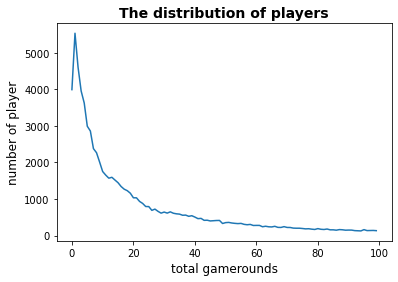

In [4]:
# The distribution of game rounds

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby("sum_gamerounds")["userid"].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot()
plt.title("The distribution of players", fontweight="bold", size=14)
plt.xlabel("total gamerounds", size=12)
plt.ylabel("number of player", size=12)
plt.show()

In the plot above we can see that some players install the game but then never play it (0 game rounds). Let's find there are how many of them.

In [5]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

<p><img src="https://assets.datacamp.com/production/project_184/img/belle_cookie.png" style="width:150px; float:right"> </p>

3994 players never played the game, just installed it. Is it too much? 

A common metric in the video gaming industry for how fun and engaging a game is retention: The percentage of players that come back and play the game 1-day and 7-days after they have installed it. The higher retention is, the easier it is to retain players and build a large player base.

As a first step, let's look at what 1-day and 7-days retentions are overall.

In [6]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


So, a little less than half of the players come back one day after installing the game. 18 percent of the players come back 7 day after installing the game. 

Now that we have a benchmark, let's look at how retention rates differs between the two A/B groups.

In [7]:
# Calculating 1-day and 7-days retention for each A/B group
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


<p><img src="https://assets.datacamp.com/production/project_184/img/ziggy_smiling.png" style="width:150px; float:left;margin:20px 10px 5px 5px;"> </p>

* There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%). 

* Again,a decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control group when it was at level 30 (19.8%). 

* It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use **bootstrapping.**

## <font color="#00bfff"> 4. A/B Testing: Bootstrapping </font>

**Definiton of Method**

<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Stratified_sampling.PNG/300px-Stratified_sampling.PNG" style=" float: right;margin:5px 20px 5px 1px; max-width:250px"></p>

We'll use **bootstrapping** for A/B testing. The basic idea of bootstrapping is that inference about a population from sample data (sample → population) can be modelled by resampling the sample data and performing inference about a sample from resampled data (resampled → sample). As the population is unknown, the true error in a sample statistic against its population value is unknown. In bootstrap-resamples, the 'population' is in fact the sample, and this is known; hence the quality of inference of the 'true' sample from resampled data (resampled → sample) is measurable. [This information retrieved from Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)

**Testing Steps:**
1. Creating 500 samples of dataset **(bootstraping)**
2. Calculating 1-day & 7-days retentions for A/B groups
3. Plotting the bootstrap distributions
4. Calculating retention rate difference between the two A/B groups
5. Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30
6. Evaluating results and making recommendation

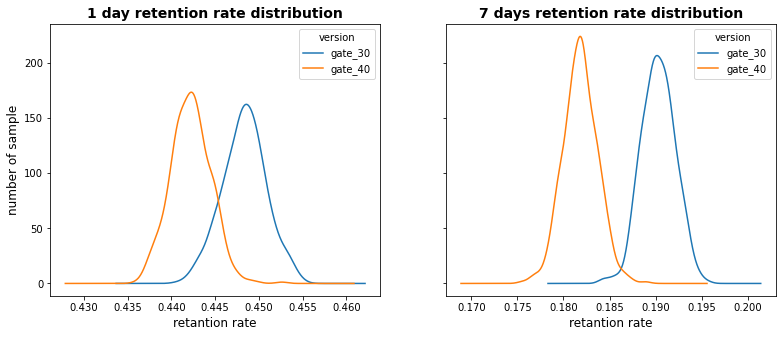

In [8]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day & 7-days retention could be for the two A/B groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the differences.</p>
<p>(<em>Note that in this notebook we have limited the number of bootstrap replication to 500 to keep the calculations quick. In "production" we would likely increase this to a much larger number, say, 10 000.</em>)</p>

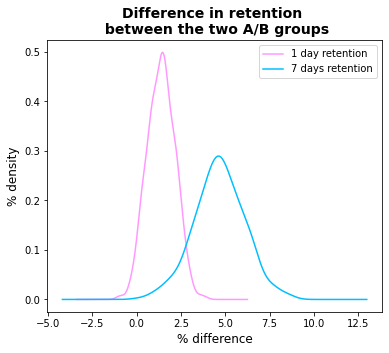

In [9]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

<p><img src="https://assets.datacamp.com/production/project_184/img/ziggy_smiling.png" style="width:100px; float:left; margin:10px 10px 5px 5px;"> </p>
<p>From these chart, we can see that the most likely % difference is around 1% - 2% for 1-day retention. For 7-days retention the most likely % difference is around 2% - 5%. Moreover, the most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? Let's calculate that as well.</p>

In [10]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 97.0%       
The probability that 7-days retention is greater when the gate is at level 30: 100.0% 


## <font color="00bfff">5. The conclusion</font>

<p><img src="https://assets.datacamp.com/production/project_184/img/cookie_yellow.png" style="width:150px; float:right"> </p>

The bootstrap result tells us that there is strong evidence **99.8% probability** that 7-day retention is higher when the gate is at level 30 than when it is at level 40.

The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics.

You can reach the case study from [DataCamp](https://www.datacamp.com/projects/184) ❤️